In [3]:
# importing cell
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Data Generation

## Lorenz system

The first dynamical system we will explore is the renowned Lorenz system of differential equations:

$$
\begin{cases}
\dot{x} = \sigma(y-x) \\ 
\dot{y} = x(\rho - z) - y \\
\dot{z} = xy - \beta z
\end{cases}
$$

Where the parameters $\sigma, \rho, \beta$ are assumed to be positive. We will set their value to 

$$
\begin{cases}
\sigma = 10 \\ 
\rho = 28 \\ 
\beta = \frac{8}{3}
\end{cases}
$$

These are the values used originally by Lorenz, and they spawn chaotic solutions that will almost always (depending on the initial condition) tend to an invariant set, the Lorenz attractor:

In [27]:
def lorenz(r,t,sigma,rho,beta):
    """
    Function to implement the Lorenz system of differential equation. Takes in two arguments:
    r : array of 3 floats representing (x,y,z)
    t : float for time value; unused by the Lorenz system but here for scipy compatibility.
    sigma :
    rho :
    beta : parameters (float)
    Returns:
    drdt : velocity vector
    """
    x,y,z = r
    return np.array([sigma*(y-x),x*(rho-z) - y,x*y - beta*z])

sigma = 10
rho = 28
beta = 8/3

r0 = np.ones(3)

N = 10000
T = 10

t = np.linspace(0,T,N)


We will use `scipy`'s `odeint` routine, which solves systems of ordinary differential equations using Isoda from FORTRAN's library.

In [28]:
r,info = odeint(lorenz,r0,t,args=(sigma,rho,beta),full_output=True) # output is like (N,3)

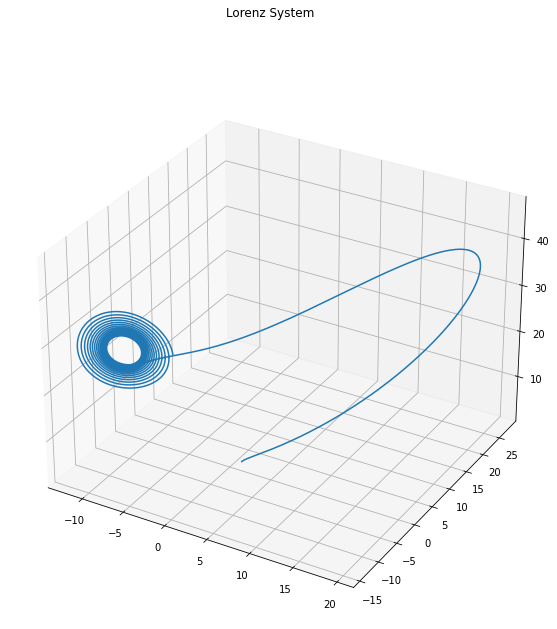

In [29]:
fig = plt.figure(figsize=[10,10])
fig.suptitle("Lorenz System")
ax = fig.add_subplot(projection='3d')
ax.plot(r[:,0],r[:,1],r[:,2])

In [30]:
! mkdir -p data
np.save("./data/lorenz_r",r)
np.save("./data/lorenz_t",t)